This notebook conduct dataset cleaning on CICIDS2017 in the following aspect:
* remove space before each feature names
* assign 0 for non-negative features when there is negative values
* drop zero variance columns (only have 1 unique value)
* remove inf, -inf, nan, and duplicate rows
* drop columns with identical values

However, two recent papers [1](#first), [2](#second) have been discussing that CIC-IDS-2017 and CSE-CIC-IDS-2018 have many errors throughout the dataset creation lifecycle, such as in attack orchestration, feature generation, documentation, and labeling.
* Attack orchestration errors: These are errors that occur during the execution of the attack scenarios on the network.
* Feature generation errors: These are errors that occur during the extraction of features from the network traffic using CICFlowMeter.
* Documentation errors: These are errors that occur during the description and explanation of the datasets and their components. 
* Labeling errors: These are errors that occur during the assignment of labels to the network flows based on their class or category.

[1](#first) have published their improved version of these two datasets [here](https://intrusion-detection.distrinet-research.be/CNS2022/Dataset_Download.html).

In [5]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter


# Original CICIDS2017

In [13]:
def process_csv(filename, label):
  csv_df = pd.read_csv(filename)
  csv_df['label'] = label
  print(filename)
  return csv_df

In [15]:
dataset_csv_path = './Dataset/SimulatedCVE' 
csv_file_names = ['dos_ge_dr.csv',
                  'ptbrowsing.csv',
                #   'stream.csv'
                  #'dos_stream.csv',
]
df_record = []
for csv_file_name in csv_file_names:
    complete_path = os.path.join(dataset_csv_path, csv_file_name)
    csv_df = process_csv(complete_path, csv_file_name)
    df_record.append(csv_df)
    
concatenated_df = pd.concat(df_record, ignore_index=True)
concatenated_df    



./Dataset/SimulatedCVE/dos_ge_dr.csv
./Dataset/SimulatedCVE/ptbrowsing.csv


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,Fwd IAT Min,PSH Flag Count,Fwd Packets/s,Bwd Header Length,label
0,64260,78.840674,502,74608,302.591581,134.687615,5882145,66,521000,42628,26050,137.987825,0,56519,74605,0,9185,0.349158,852560,./Dataset/SimulatedCVE/dos_ge_dr.csv
1,64260,303.408920,64240,19999,303.877612,134.932206,6067875,66,538280,44022,26914,137.837331,0,1638,19998,0,9495,1.345767,880440,./Dataset/SimulatedCVE/dos_ge_dr.csv
2,64260,298.099757,64240,20971,324.400761,138.567478,6251450,66,556900,45409,27845,137.669845,0,1538,20970,0,9905,1.327786,908180,./Dataset/SimulatedCVE/dos_ge_dr.csv
3,64260,241.537172,64240,21118,334.267090,148.840225,5100782,60,419140,33363,20957,152.887390,0,5118,21117,0,8298,0.992376,667260,./Dataset/SimulatedCVE/dos_ge_dr.csv
4,64260,139.985616,64240,20787,512.097618,218.140341,2909881,60,221820,16100,11091,180.737950,0,5118,20782,0,6018,0.533555,322000,./Dataset/SimulatedCVE/dos_ge_dr.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,64260,2.681169,64240,52934,1971.671141,1164.977538,141925,66,24240,1103,1212,128.671804,0,15715,52929,0,1212,0.022896,22060,./Dataset/SimulatedCVE/ptbrowsing.csv
255,501,2.120962,586,51198,1963.572650,1124.398112,108589,66,18840,859,942,126.413271,0,13154,51197,0,902,0.018399,17180,./Dataset/SimulatedCVE/ptbrowsing.csv
256,501,1.152327,586,51698,1815.092859,968.061263,59573,66,10936,513,548,116.126706,0,8187,51694,0,456,0.010600,10260,./Dataset/SimulatedCVE/ptbrowsing.csv
257,501,1.490920,568,53249,1743.345087,968.619958,79390,66,14576,683,730,116.237189,0,10239,53248,0,626,0.013709,13660,./Dataset/SimulatedCVE/ptbrowsing.csv


In [3]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
df = clean_df(df)

dataset shape (2830743, 79)
zero variance columns ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] dropped
shape after removing zero variance columns: (2830743, 71)
2867 rows dropped
shape after removing nan: (2827876, 71)
shape after dropping duplicates: (2520798, 71)
columns which have identical values [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')] dropped
shape after removing identical value columns: (2520798, 66)


In [4]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

# Improved CICIDS2017

In [5]:
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = ['monday.csv', 
                  'tuesday.csv', 
                  'wednesday.csv', 
                  'thursday.csv', 
                  'friday.csv']

complete_paths = []
for csv_file_name in csv_file_names:
    complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                        ignore_index = True)

In [6]:
dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                 'Dst Port', 'Timestamp']
improved_df = clean_df(improved_df)
improved_df.drop(dropping_cols, axis = 1, inplace = True)
improved_df['Label'].value_counts()

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


Label
BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                    

In [7]:
improved_df['Label'].value_counts()

Label
BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                    

In [9]:
improved_df['Attempted Category'].value_counts()

Attempted Category
0    2092837
1       4067
6       2804
5        138
4         75
3         27
2         23
Name: count, dtype: int64

Although the flows of attempted attacks have malicious intents,they don't have anomaly effect on the system due to the following reasons [3](#third):
* Category 0 - No payload sent by attacker
* Category 1 - Port/System closed
* Category 2 - Attack Startup/Teardown Artefact
* Category 3 - No malicious payload
* Category 4 - Attack Artefact
* Category 5 - Attack Implemented Incorrectly
* Category 6 - Target System Unresponsive

For these kinds of attempted labels, we have a choice to treat them as benign or malicious.

In most cases of network intrusion detection, we process each flow separately, so the classifier can only see only flow at a time and doesn't know the context.

As a result, they are re-labeled as BENIGN [4](#fourth).

In [10]:
attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]

improved_df.drop(['Attempted Category'], axis = 1, inplace = True)

improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
improved_df['Label'].value_counts()

Label
BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

# 2D-PCA visualization

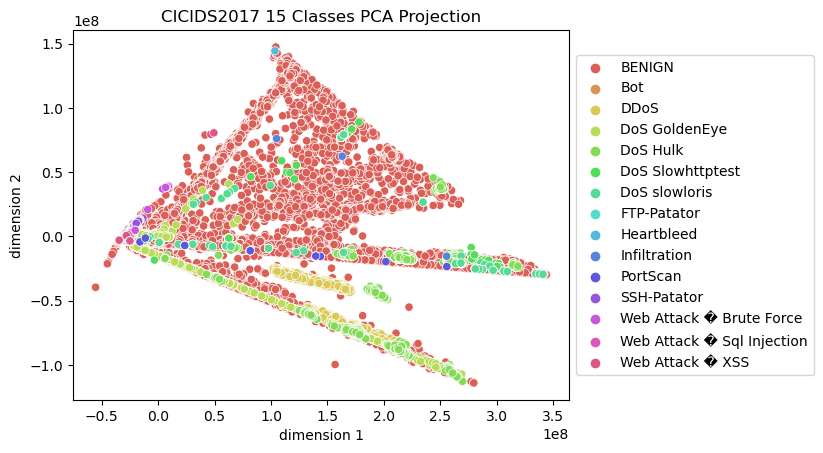

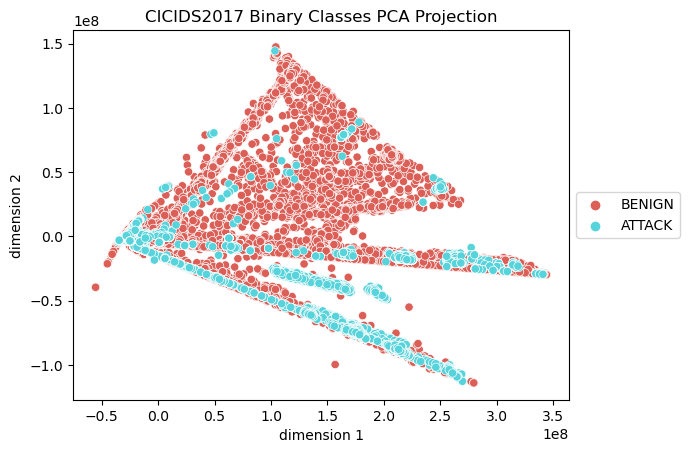

In [10]:
# https://stackoverflow.com/questions/43640952/how-to-subsample-a-pandas-dataframe-respecting-the-frequency-of-each-class
subsample_df = df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

pca_2_df = pd.DataFrame()
pca_2_df['Label'] = y
pca_2_df.loc[pca_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
pca_2_df['dimension 1'] = z[:, 0]
pca_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = pca_2_df).set(title = 'CICIDS2017 Binary Classes PCA Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

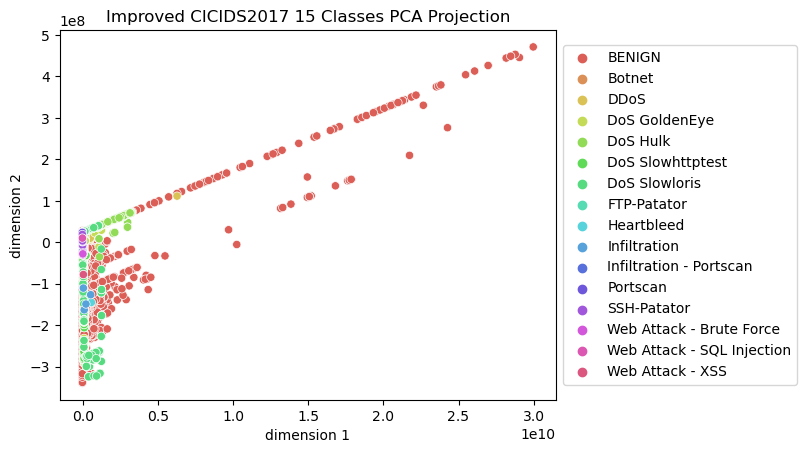

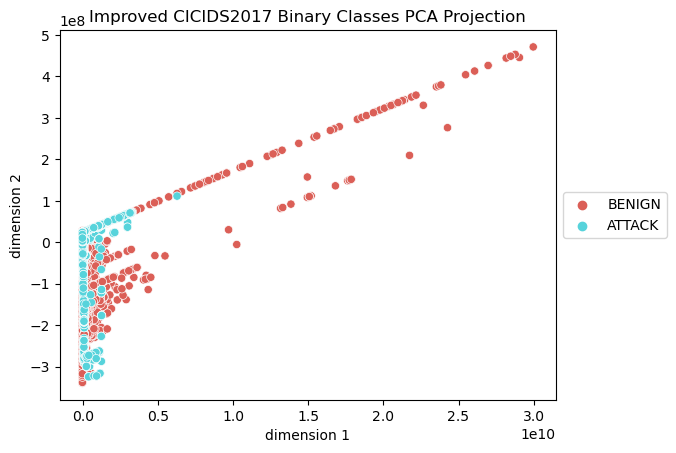

In [11]:
subsample_improved_df = improved_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_improved_df.drop(['Label'], axis = 1)
y = subsample_improved_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'Improved CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

pca_2_df = pd.DataFrame()
pca_2_df['Label'] = y
pca_2_df.loc[pca_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
pca_2_df['dimension 1'] = z[:, 0]
pca_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = pca_2_df).set(title = 'Improved CICIDS2017 Binary Classes PCA Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

# 2D-TSNE visualization

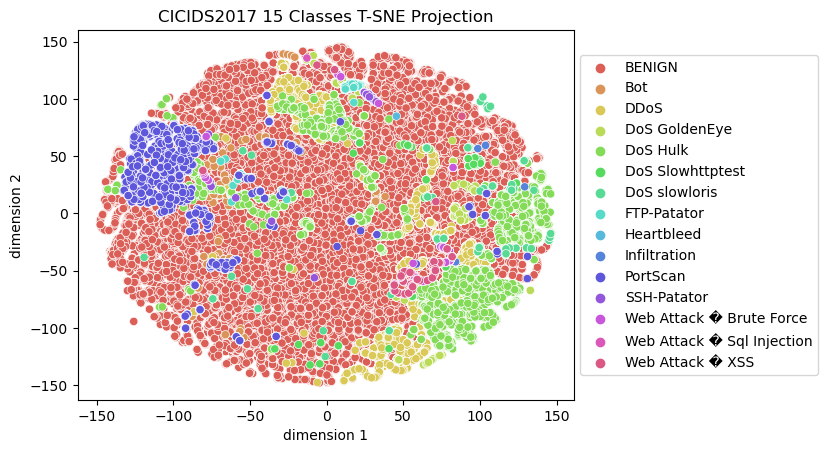

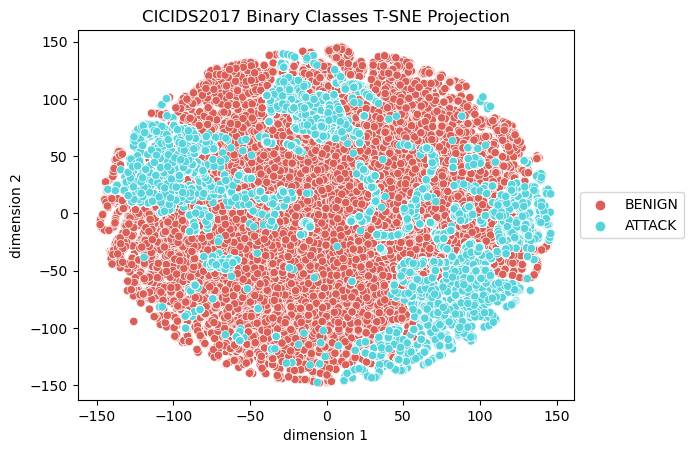

CPU times: user 2h 19min 59s, sys: 2min 8s, total: 2h 22min 8s
Wall time: 45min 36s


In [12]:
%%time
X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

tsne = TSNE(n_components = 2, n_jobs = -1, verbose = 0, random_state = 0)
z = tsne.fit_transform(X) 

tsne_15_df = pd.DataFrame()
tsne_15_df['Label'] = y
tsne_15_df['dimension 1'] = z[:, 0]
tsne_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_15_df.Label,
                palette = sns.color_palette('hls', len(tsne_15_df.Label.value_counts())),
                data = tsne_15_df).set(title = 'CICIDS2017 15 Classes T-SNE Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

tsne_2_df = pd.DataFrame()
tsne_2_df['Label'] = y
tsne_2_df.loc[tsne_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
tsne_2_df['dimension 1'] = z[:, 0]
tsne_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = tsne_2_df).set(title = 'CICIDS2017 Binary Classes T-SNE Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

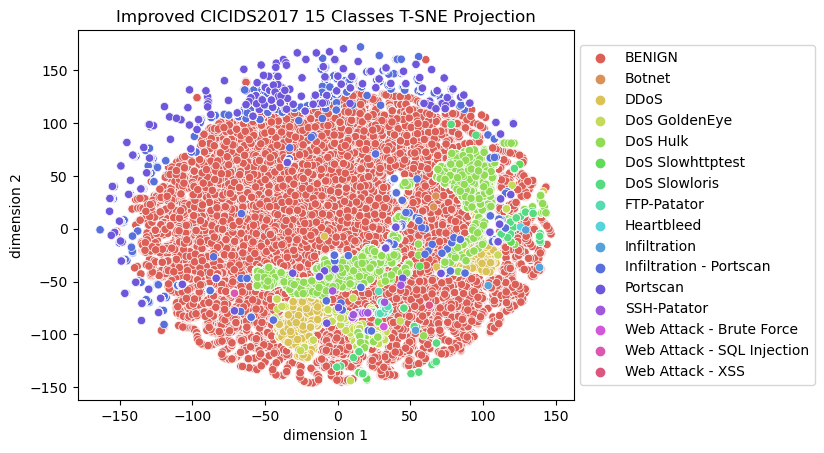

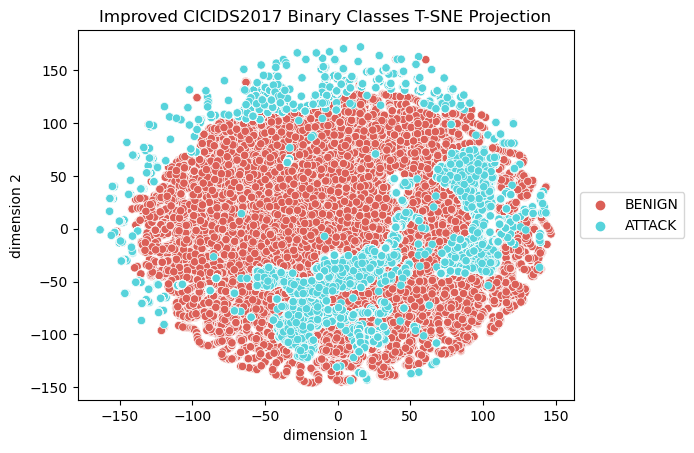

CPU times: user 1h 52min 24s, sys: 1min 41s, total: 1h 54min 6s
Wall time: 37min 41s


In [13]:
%%time
X = subsample_improved_df.drop(['Label'], axis = 1)
y = subsample_improved_df['Label']

tsne = TSNE(n_components = 2, n_jobs = -1, verbose = 0, random_state = 0)
z = tsne.fit_transform(X) 

tsne_15_df = pd.DataFrame()
tsne_15_df['Label'] = y
tsne_15_df['dimension 1'] = z[:, 0]
tsne_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_15_df.Label,
                palette = sns.color_palette('hls', len(tsne_15_df.Label.value_counts())),
                data = tsne_15_df).set(title = 'Improved CICIDS2017 15 Classes T-SNE Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

tsne_2_df = pd.DataFrame()
tsne_2_df['Label'] = y
tsne_2_df.loc[tsne_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
tsne_2_df['dimension 1'] = z[:, 0]
tsne_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = tsne_2_df).set(title = 'Improved CICIDS2017 Binary Classes T-SNE Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

# XGBoost-ShapValues

# Updated Dataset

In [117]:
subsample_improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], 
                                   improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=0.15, random_state=42)]) 
subsample_improved_df.sample(frac=0.1)


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
2046577,6,5293933,4,2,0,0,0,0,0.000000,0.000000,...,36779,36779,5.220004e+06,0.000000e+00,5220004,5220004,0,0,5293933,BENIGN
1534322,6,73670782,18,19,1703,11328,517,0,94.611111,177.051385,...,208551,30901,1.000051e+07,4.560978e+03,10006528,9994366,0,0,73670782,BENIGN
1010222,17,187,2,2,94,350,47,47,47.000000,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN
1699967,17,199,2,2,90,202,45,45,45.000000,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN
602140,17,100185,2,2,76,194,38,38,38.000000,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490001,6,3069336,14,17,1305,16863,491,0,93.214286,178.713857,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,3069336,BENIGN
425272,17,65958,4,2,160,350,40,40,40.000000,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN
165018,6,172989,12,7,1603,767,1349,0,133.583333,385.515584,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,172989,BENIGN
2082210,6,7919202,9,4,20,11595,20,0,2.222222,6.666667,...,1333381,1333381,6.585821e+06,0.000000e+00,6585821,6585821,0,0,7919202,DDoS


In [118]:

counter_dict = Counter(subsample_improved_df['Label'])
n_benign = counter_dict["BENIGN"]
n_malicious = subsample_improved_df.shape[0]-n_benign
print(f'Benign : Malicious = {n_benign/n_malicious} : {1}')
print("Shape of df = ", subsample_improved_df.shape)
X = subsample_improved_df.drop(['Label'], axis = 1)
y = subsample_improved_df['Label']

Benign : Malicious = 21.031985754797862 : 1
Shape of df =  (1670355, 83)


In [119]:
pca_10d = PCA(n_components=10)
res_10d = pca_10d.fit_transform(X)
pca_10d_df = pd.DataFrame(data=res_10d, columns = [f'PC{i+1}' for i in range(res_10d.shape[1])])
print('Explained variation per principal component: {}'.format(pca_10d.explained_variance_ratio_))



Explained variation per principal component: [9.70225268e-01 2.31291256e-02 4.70297828e-03 9.30715028e-04
 2.38206010e-04 2.18079261e-04 1.96536687e-04 1.16295683e-04
 6.06181919e-05 5.48023547e-05]


In [126]:
from sklearn.ensemble import IsolationForest
iso_forest=IsolationForest(n_estimators=100,max_samples='auto',contamination='auto',random_state=0)
iso_forest.fit(res_10d)
scores = iso_forest.decision_function(res_10d)
anomaly_scores = iso_forest.predict(res_10d)
pca_10d_df['scores'] = anomaly_scores
pca_10d_df['isoF_scores'] = scores
pca_10d_df['strLabel'] = y

pca_10d_df


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,scores,isoF_scores,strLabel
0,-3.216456e+07,-1.083569e+08,-4.010084e+07,3.300670e+06,7.246038e+07,-2.919917e+06,-1.405850e+06,3.150074e+07,3.885605e+07,4.080344e+07,-1,-0.209000,BENIGN
1,-3.182670e+07,-1.482580e+08,6.825336e+07,6.155867e+07,-5.823715e+06,-2.374398e+06,-1.323091e+05,-4.305578e+06,-9.337815e+06,7.529840e+06,-1,-0.096424,BENIGN
2,-3.199869e+07,-1.208493e+08,-8.595899e+06,2.490027e+07,7.835493e+07,-3.140669e+06,-1.523923e+06,4.819697e+07,4.144080e+07,2.597572e+07,-1,-0.224294,BENIGN
3,-3.192548e+07,-1.399811e+08,5.070433e+07,5.105053e+07,-3.167027e+06,-2.064949e+06,-1.225789e+05,-5.165497e+06,3.172918e+05,3.871177e+06,-1,-0.017141,BENIGN
4,-3.188772e+07,-1.426733e+08,5.172385e+07,5.204282e+07,-3.240588e+06,-2.088489e+06,-1.138753e+05,-5.262279e+06,2.631992e+05,3.923108e+06,-1,-0.021010,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670350,-3.412188e+07,2.797961e+07,6.749363e+05,-4.639445e+05,-1.887941e+05,-5.723448e+05,-6.084619e+05,-1.575936e+05,1.224621e+05,-1.314090e+05,1,0.186882,DDoS
1670351,-3.429991e+07,2.833824e+07,6.619832e+05,-5.441188e+05,-1.744702e+05,-7.136177e+05,-6.466780e+05,-2.563225e+05,6.773406e+04,-1.459490e+05,1,0.192579,NaN
1670352,-3.412708e+07,2.791472e+07,5.117686e+05,-3.563675e+04,1.466552e+05,2.082377e+07,-5.565390e+05,5.786176e+04,-3.655505e+05,9.915440e+04,1,0.068761,NaN
1670353,-3.429993e+07,2.833826e+07,6.619790e+05,-5.441162e+05,-1.744850e+05,-7.136136e+05,-6.465457e+05,-2.563289e+05,6.774263e+04,-1.459517e+05,1,0.192579,NaN


/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_30969/1977819299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_df['strLabel'] = y
/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_30969/1977819299.py:4: UserWarning: 
The palette list has fewer values (6) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=pca_10d_df, x='isoF_scores', hue='strLabel', palette=sns.color_palette("hls",6), kde=True, bins=100)  # KDE adds a density plot


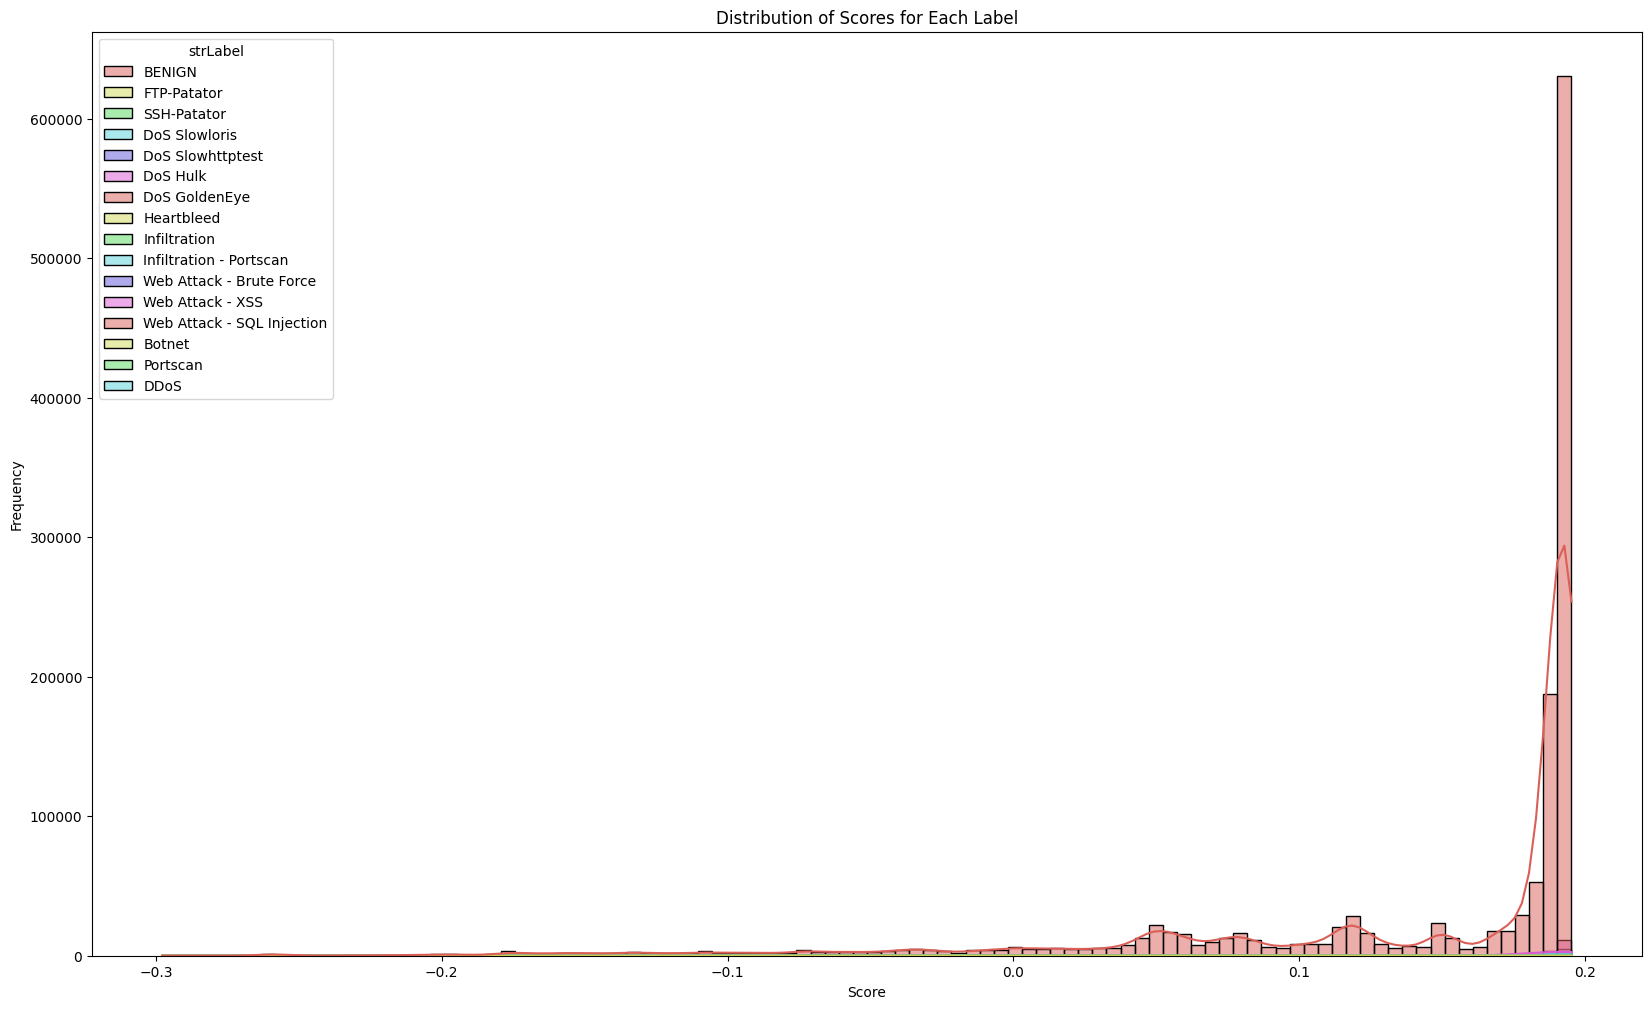

In [127]:
plt.figure(figsize=(20, 12))
att_df = pca_10d_df.loc[pca_10d_df['strLabel'] !="BENIGN"]
att_df['strLabel'] = y
sns.histplot(data=pca_10d_df, x='isoF_scores', hue='strLabel', palette=sns.color_palette("hls",6), kde=True, bins=100)  # KDE adds a density plot
plt.title('Distribution of Scores for Each Label')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [128]:
from umap.umap_ import UMAP

reducer = UMAP(n_neighbors=50,
                    min_dist=0.0,
                    n_components=2)
pca_reduced = reducer.fit_transform(pca_10d_df.iloc[:,:10])
pca_reduced_df = pd.DataFrame(pca_reduced)
pca_reduced_df['strLabel'] = y[:]

/Users/shehvincent/anaconda3/envs/edge_computing/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

<Axes: xlabel='0', ylabel='1'>

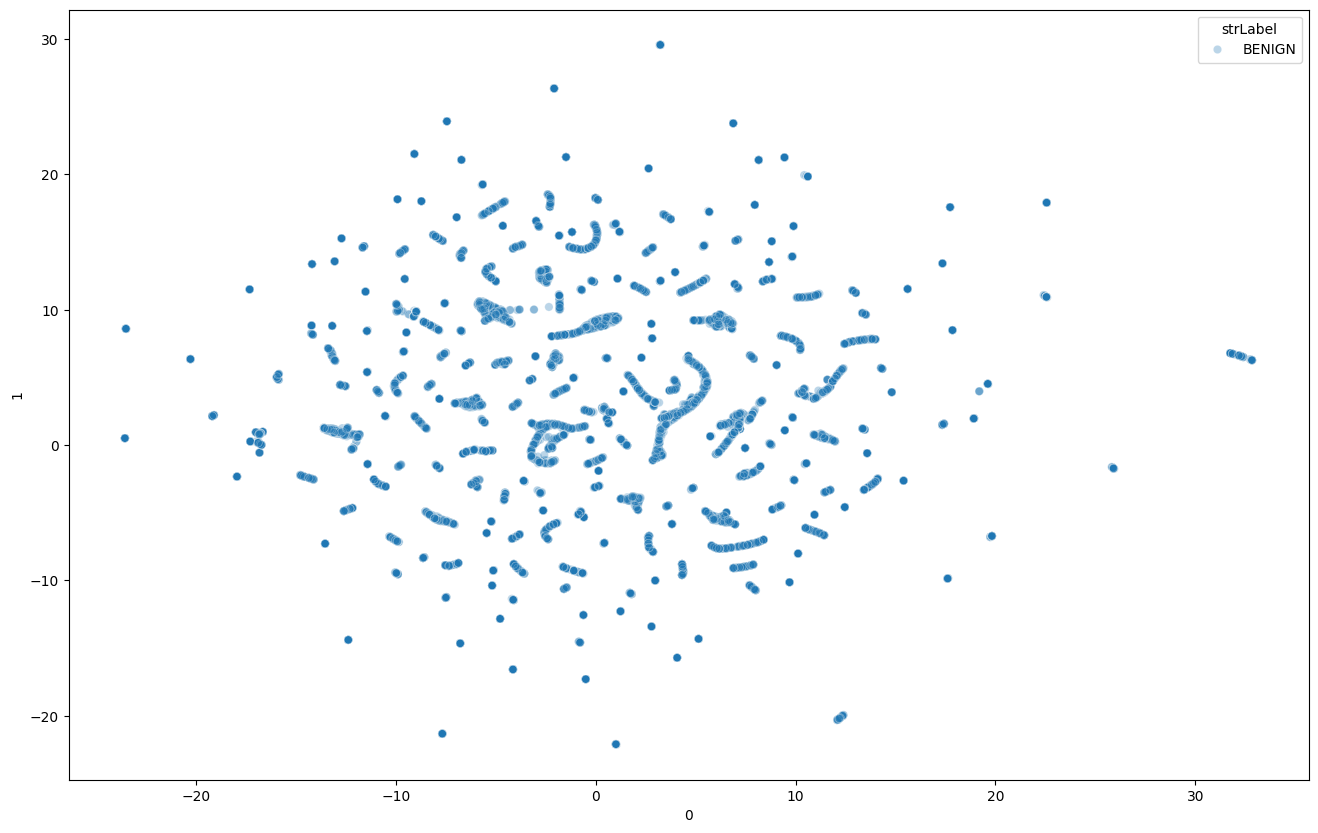

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=1,
    hue='strLabel',
    data=pca_reduced_df,
    legend='full',
    alpha=0.3,
)


# Original Dataset

### PCA => Isolation Forest => Anomaly Scores Distribution Plot => UMAP Visualization

In [22]:
subsample_df = df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.08).reset_index(drop = True)
counter_dict = Counter(df['Label'])
n_benign = counter_dict["BENIGN"]
n_malicious = subsample_df.shape[0]-counter_dict[0]
print(f'Benign : Malicious = {n_benign/n_malicious} : {1}')
print("Shape of df = ", subsample_df.shape)
X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

Benign : Malicious = 10.388746739658643 : 1
Shape of df =  (201666, 66)


In [34]:
pca_10d = PCA(n_components=10)
res_10d = pca_10d.fit_transform(X)
pca_10d_df = pd.DataFrame(data=res_10d, columns = [f'PC{i+1}' for i in range(res_10d.shape[1])])
print('Explained variation per principal component: {}'.format(pca_10d.explained_variance_ratio_))



Explained variation per principal component: [0.7035349  0.12274705 0.08569598 0.04667591 0.02301106 0.00876145
 0.00372066 0.00137609 0.00130954 0.00100356]


In [43]:
from sklearn.ensemble import IsolationForest
iso_forest=IsolationForest(n_estimators=100,max_samples='auto',contamination=1/15,random_state=0)
iso_forest.fit(res_10d)
scores = iso_forest.decision_function(res_10d)
anomaly_scores = iso_forest.predict(res_10d)
pca_10d_df['scores'] = anomaly_scores
pca_10d_df['isoF_scores'] = scores
pca_10d_df['strLabel'] = y

pca_10d_df


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,scores,isoT_scores,isoF_scores,strLabel
0,-3.408220e+07,-2.737990e+06,-1.797233e+06,1.486558e+06,-3.705601e+05,-1.812306e+05,-1.141271e+05,9.976343e+04,-23190.526109,2.893888e+03,1,0.274311,0.220466,BENIGN
1,-3.468835e+07,-2.934576e+06,-5.658219e+05,1.113916e+06,-6.962833e+05,-3.647682e+05,-2.001650e+05,2.190559e+05,-48177.911760,-1.344237e+05,1,0.287717,0.233871,BENIGN
2,-3.460218e+07,-2.917370e+06,-1.804408e+06,1.098264e+06,-6.616206e+05,-3.243218e+05,-1.111386e+05,2.243906e+05,-48646.945847,-1.083739e+05,1,0.290545,0.236699,BENIGN
3,-3.274679e+07,-1.894503e+06,-1.769923e+06,2.186003e+06,-1.463840e+06,2.371584e+05,1.017539e+05,-1.332201e+05,24036.397606,2.378995e+05,1,0.251004,0.197158,BENIGN
4,-2.066152e+07,-7.582589e+06,-1.750599e+06,-1.944513e+06,1.176281e+05,-9.475407e+05,-3.535921e+05,2.635751e+05,-49018.800952,-3.340509e+04,1,0.253839,0.199993,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201661,-2.602557e+07,-3.400274e+06,-1.754570e+06,-1.394413e+06,1.872977e+06,3.587792e+06,1.806866e+06,-4.338934e+06,801056.739065,1.229624e+06,1,0.165376,0.111530,Web Attack � XSS
201662,-2.607865e+07,-3.397312e+06,-1.754895e+06,-1.378986e+06,1.857198e+06,3.563535e+06,1.794543e+06,-4.310968e+06,795844.758180,1.221253e+06,1,0.165376,0.111530,Web Attack � XSS
201663,-2.532617e+07,-3.439350e+06,-1.750288e+06,-1.597710e+06,2.080835e+06,3.907458e+06,1.969162e+06,-4.707537e+06,869752.640251,1.339932e+06,1,0.158942,0.105096,Web Attack � XSS
201664,-2.597353e+07,-3.403176e+06,-1.754251e+06,-1.409539e+06,1.888451e+06,3.611576e+06,1.818950e+06,-4.366352e+06,806166.595547,1.237832e+06,1,0.165376,0.111530,Web Attack � XSS


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.408220e+07,-2.737990e+06,-1.797233e+06,1.486558e+06,-3.705601e+05,-1.812306e+05,-1.141271e+05,9.976343e+04,-23190.526109,2.893888e+03
1,-3.468835e+07,-2.934576e+06,-5.658219e+05,1.113916e+06,-6.962833e+05,-3.647682e+05,-2.001650e+05,2.190559e+05,-48177.911760,-1.344237e+05
2,-3.460218e+07,-2.917370e+06,-1.804408e+06,1.098264e+06,-6.616206e+05,-3.243218e+05,-1.111386e+05,2.243906e+05,-48646.945847,-1.083739e+05
3,-3.274679e+07,-1.894503e+06,-1.769923e+06,2.186003e+06,-1.463840e+06,2.371584e+05,1.017539e+05,-1.332201e+05,24036.397606,2.378995e+05
4,-2.066152e+07,-7.582589e+06,-1.750599e+06,-1.944513e+06,1.176281e+05,-9.475407e+05,-3.535921e+05,2.635751e+05,-49018.800952,-3.340509e+04
...,...,...,...,...,...,...,...,...,...,...
201661,-2.602557e+07,-3.400274e+06,-1.754570e+06,-1.394413e+06,1.872977e+06,3.587792e+06,1.806866e+06,-4.338934e+06,801056.739065,1.229624e+06
201662,-2.607865e+07,-3.397312e+06,-1.754895e+06,-1.378986e+06,1.857198e+06,3.563535e+06,1.794543e+06,-4.310968e+06,795844.758180,1.221253e+06
201663,-2.532617e+07,-3.439350e+06,-1.750288e+06,-1.597710e+06,2.080835e+06,3.907458e+06,1.969162e+06,-4.707537e+06,869752.640251,1.339932e+06
201664,-2.597353e+07,-3.403176e+06,-1.754251e+06,-1.409539e+06,1.888451e+06,3.611576e+06,1.818950e+06,-4.366352e+06,806166.595547,1.237832e+06


##### UMAP Visualization

In [65]:
from umap.umap_ import UMAP

reducer = UMAP(n_neighbors=50,
                    min_dist=0.0,
                    n_components=2)
pca_reduced = reducer.fit_transform(pca_10d_df.iloc[:,:10])
pca_reduced_df = pd.DataFrame(pca_reduced)
pca_reduced_df['strLabel'] = y

/Users/shehvincent/anaconda3/envs/edge_computing/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

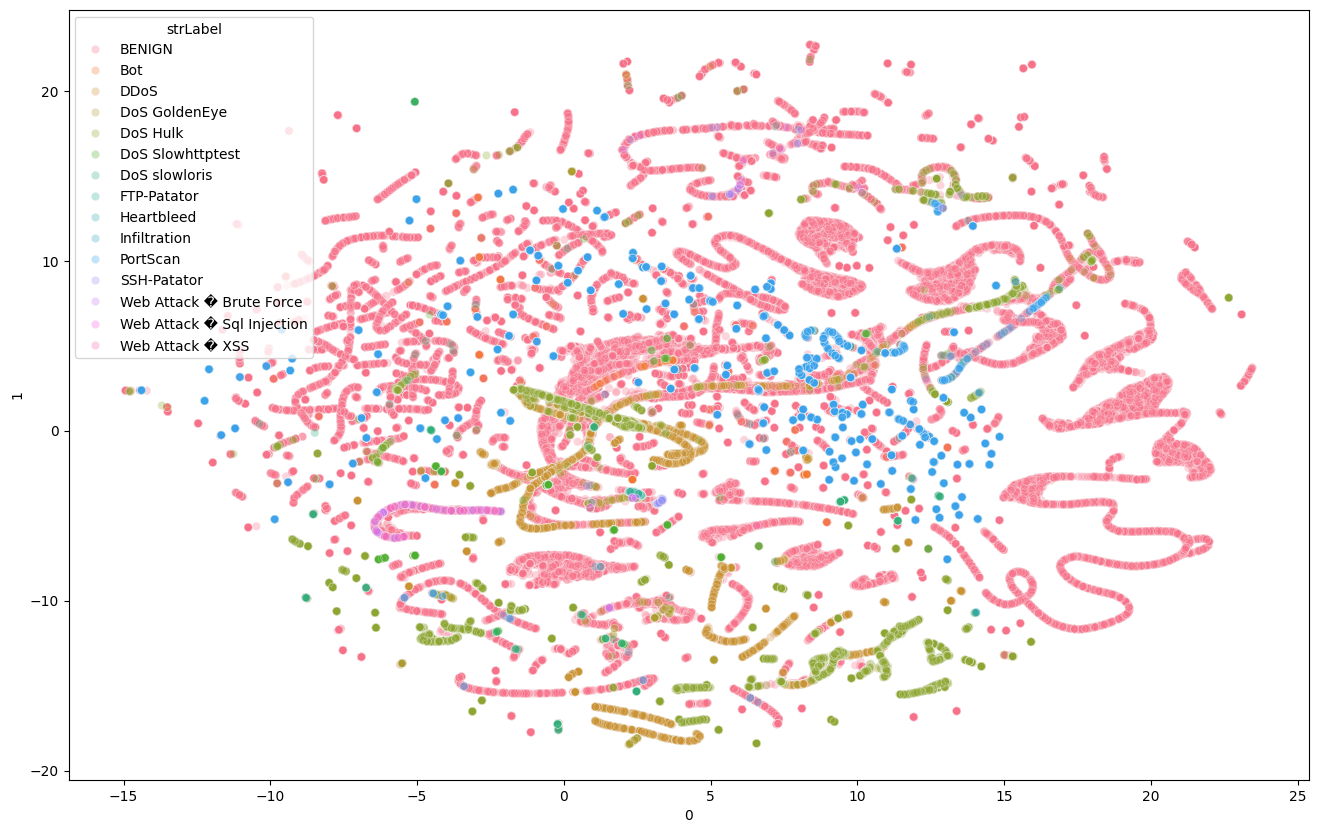

In [67]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=1,
    hue='strLabel',
    data=pca_reduced_df,
    legend='full',
    alpha=0.3,
)


##### Anomaly Score Distribution for each Labels

/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_30969/3224369868.py:4: UserWarning: 
The palette list has fewer values (6) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=pca_10d_df, x='isoF_scores', hue='strLabel', palette=sns.color_palette("hls",6), kde=True, bins=100)  # KDE adds a density plot


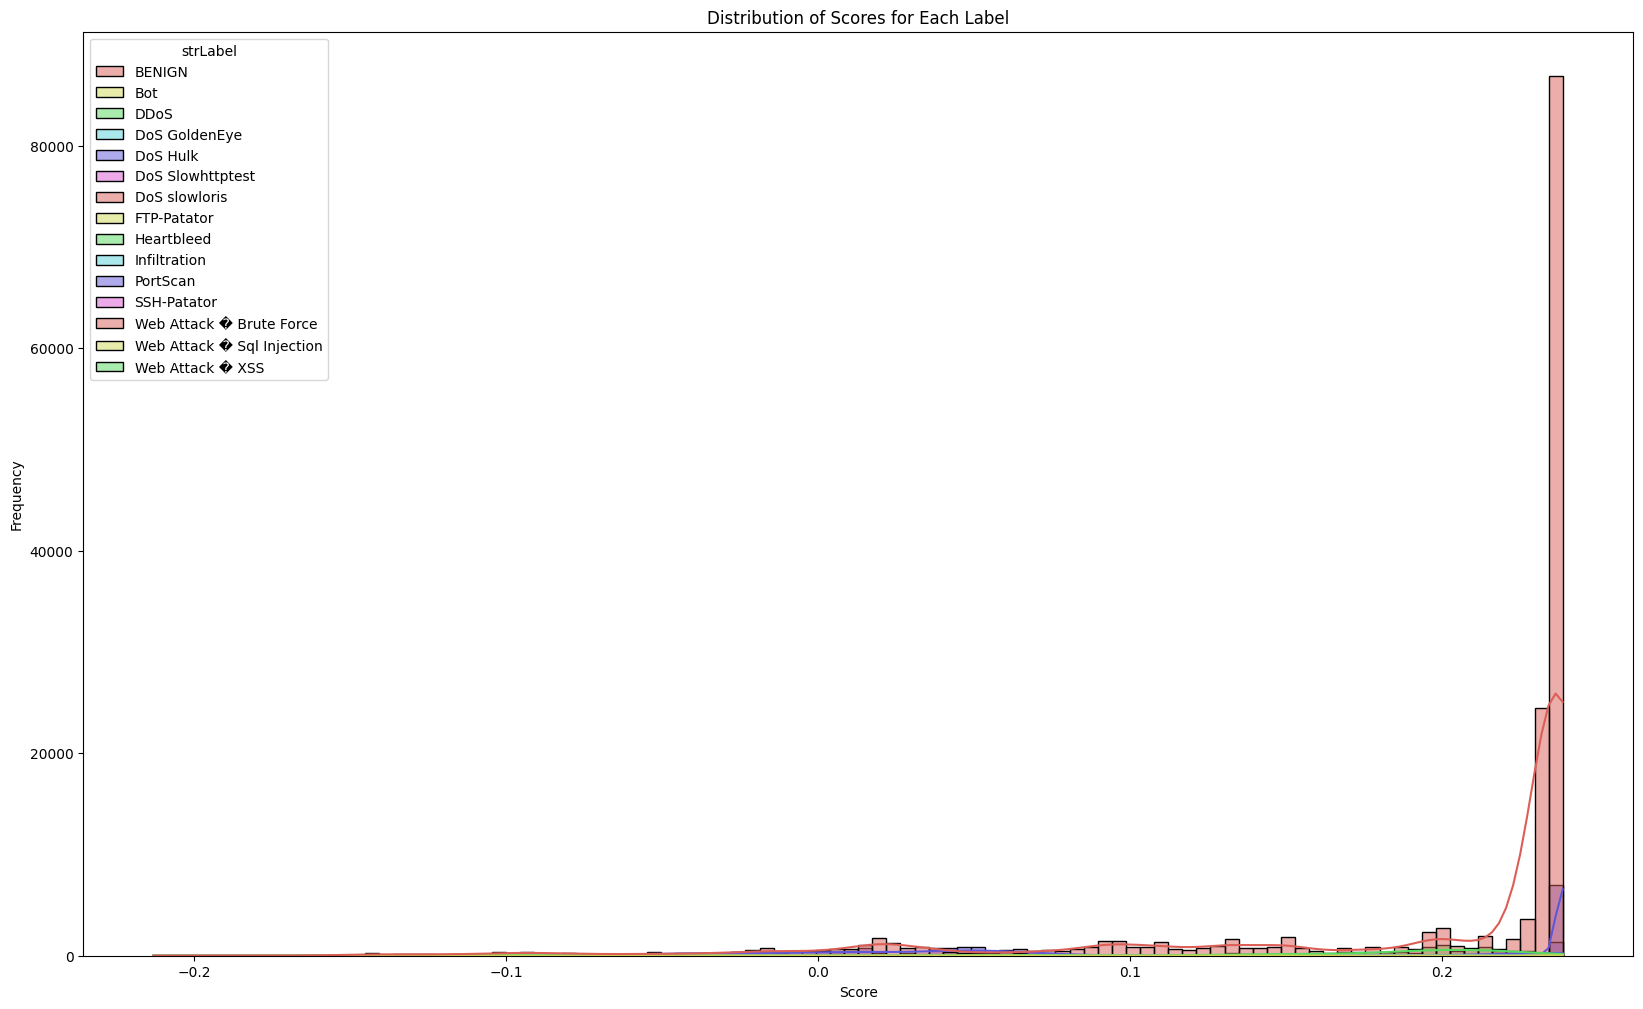

In [44]:
plt.figure(figsize=(20, 12))
# att_df = pca_10d_df.loc[pca_10d_df['strLabel'] !="BENIGN"]
# att_df['strLabel'] = y
sns.histplot(data=pca_10d_df, x='isoF_scores', hue='strLabel', palette=sns.color_palette("hls",6), kde=True, bins=100)  # KDE adds a density plot
plt.title('Distribution of Scores for Each Label')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Reference
1. <a id='first'></a>[Liu, Lisa, et al. "Error prevalence in nids datasets: A case study on cic-ids-2017 and cse-cic-ids-2018." 2022 IEEE Conference on Communications and Network Security (CNS). IEEE, 2022.](https://ieeexplore.ieee.org/abstract/document/9947235)
2. <a id='second'></a>[Lanvin, Maxime, et al. "Errors in the CICIDS2017 dataset and the significant differences in detection performances it makes." International Conference on Risks and Security of Internet and Systems. Cham: Springer Nature Switzerland, 2022.](https://link.springer.com/chapter/10.1007/978-3-031-31108-6_2)
3. <a id='third'></a>[Improved CIC-IDS 2017 Documentation](https://intrusion-detection.distrinet-research.be/CNS2022/CICIDS2017.html)
4. <a id='fourth'></a>[Error Prevalence in NIDS datasets: A Case Study on CIC-IDS-2017 and CSE-CIC-IDS-2018 (G. Engelen)](https://www.youtube.com/watch?v=sJvZKhw3lYo)
5. <a id='fifth'></a>Verkerken, Miel, et al. "Towards model generalization for intrusion detection: Unsupervised machine learning techniques." Journal of Network and Systems Management 30 (2022): 1-25.
6. <a id='sixth'></a>[CIC-IDS-2018](https://gitlab.ilabt.imec.be/mverkerk/cic-ids-2018)
7. Yang, Li, et al. "LCCDE: A decision-based ensemble framework for intrusion detection in the internet of vehicles." GLOBECOM 2022-2022 IEEE Global Communications Conference. IEEE, 2022.
8. [TSNE Visualization Example in Python](https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html)
9. [Multicore t-SNE](https://github.com/DmitryUlyanov/Multicore-TSNE)
10. [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
11. [What do maskers really do in SHAP package and fit them to train or test?](https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test)
12. [Python Statistics Fundamentals: How to Describe Your Data](https://realpython.com/python-statistics/)

Equations saved to hw5eqn.txt
Solution: [ 2.08438819 -3.91983122  2.02531646  0.0464135  12.07172996]
Solution: [ 2.08438819 -3.91983122  2.02531646  0.0464135  12.07172996]
Solution: [ 2.08438819 -3.91983122  2.02531646  0.0464135  12.07172996]
Guess 1: [0. 0. 0. 0. 0.] Guess 2: [1. 2. 3. 4. 5.] Guess 3: [ 999. -999.  999. -999.  999.]


array([[ 1.e-05,  2.e-05],
       [ 6.e-05, -1.e-05]])